# Track and summarize experimental data from 20230912

In [1]:
import os
import glob
import numpy as np
import traceback
import dclab
import dctrack

# supress warning from skimage
import warnings
warnings.filterwarnings(
    "ignore", message="divide by zero encountered in scalar divide")
warnings.filterwarnings(
    "ignore", message="invalid value encountered in scalar divide")
warnings.filterwarnings(
    "ignore", message="Polyfit may be poorly conditioned")

C:\Users\freiche\ownCloud\PhD\Code_general\rtdc_tracking2.0\dctrack\track.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
project_folder = r"..\..\raw_data\20230912_Felix_HL60_LatB_hyper_channels"
export_folder = r"..\..\tracked_data"

In [3]:
# length of hyperbolic region in um
length_hyper_region = 500
frame_max = None
timeout = None  # 1h 30m

for root, _, _ in os.walk(project_folder):
    if not "tracked_files" in root:
        rtdc_paths = glob.glob(os.path.join(root,"*.rtdc"))
        for file in rtdc_paths:
            print("Analyzing {} \n".format(file))
            # create directory with same structure as Data/RTDC to export data
            file_split = file.split("\\")
            rtdc_idx = file_split.index("RTDC")
            subfolders_export = np.array(file_split)[rtdc_idx+1:-1]
            save_folder = os.path.join(export_folder,"\\".join(subfolders_export))
            if not os.path.isdir(save_folder):
                os.makedirs(save_folder)
            video_folder = os.path.join(save_folder,"Videos")
            if not os.path.isdir(video_folder):
                os.makedirs(video_folder)

            save_path = os.path.join(save_folder, file_split[-1])
            if not os.path.isfile(save_path):
                try:
                    ds = dclab.new_dataset(file)
                    tr_ds = dctrack.track.TrackedDataSet(ds)

                    pix_size = tr_ds.pixel_size
                    tr_ds.tolerance_window = 30

                    tr_ds.channel = True
                    tr_ds.outlet = False
                    if "inlet" in file:
                        tr_ds.inlet = False
                        channel_entry = tr_ds.channel_x_min - 500/pix_size
                        tr_ds.set_channel_values_manual(x_min=0,
                                                        x_max=tr_ds.roi_size_x)
                    else:
                        tr_ds.inlet = True
                        # ROI start 50 um before channel start
                        channel_entry = tr_ds.channel_x_min + 50/pix_size
                        tr_ds.set_channel_values_manual(x_min=0,
                                                        x_max=channel_entry)
                    # start of hyperbolic region in um
                    hyper_start = channel_entry*pix_size + length_hyper_region

                    tr_ds.track(frame_min=0, frame_max=frame_max,
                                timeout=timeout,
                                max_skip_frames=8)
                    tr_ds.time_after_x(hyper_start, return_value=False,
                                       add_to_dataset=True,
                                       variable_name='time_hyper_region')
                    tr_ds.get_ellipse_data(show_progress=False)

                    frame_tracked = tr_ds.dataset['frame'][:][~np.isnan(tr_ds.dataset['object_number'][:])]
                    tr_ds.filter_feature('frame', 0, frame_tracked[-1])

                    export_features = tr_ds.dataset.features_scalar
                    if 'inert_ratio_raw' not in export_features:
                        export_features += ['inert_ratio_raw', 'inert_ratio_cvx']
                    tr_ds.export_tracked_dataset_as_hdf5(path=save_path,
                                                         features=export_features,
                                                         filtered=True,
                                                         override=True,
                                                         compression=None,
                                                         skip_checks=True)

                    video_path = os.path.join(video_folder, os.path.splitext(file_split[-1])[0]+".avi")
                    tr_ds.write_video(save_path=video_path, first_frame=1000, last_frame=3000,
                                      draw_zones=True)
                except:
                    print("An error occured. See below \n")
                    print(traceback.print_exc())

Analyzing Y:\Data\RTDC\20230912_Felix_HL60_LatB_hyper_channels\0.1nM_LatB\hyper\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230912_Felix_HL60_LatB_hyper_channels\0.1nM_LatB\hyper\M002_data.rtdc 

Analyzing Y:\Data\RTDC\20230912_Felix_HL60_LatB_hyper_channels\0.1nM_LatB\hyper\M003_data.rtdc 

Analyzing Y:\Data\RTDC\20230912_Felix_HL60_LatB_hyper_channels\0.1nM_LatB\inlet\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230912_Felix_HL60_LatB_hyper_channels\100nM_LatB\hyper\M002_data.rtdc 

Analyzing Y:\Data\RTDC\20230912_Felix_HL60_LatB_hyper_channels\100nM_LatB\hyper\M003_data.rtdc 

Analyzing Y:\Data\RTDC\20230912_Felix_HL60_LatB_hyper_channels\100nM_LatB\hyper\M004_data.rtdc 

Analyzing Y:\Data\RTDC\20230912_Felix_HL60_LatB_hyper_channels\100nM_LatB\inlet\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230912_Felix_HL60_LatB_hyper_channels\10nM_LatB\hyper\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230912_Felix_HL60_LatB_hyper_channels\10nM_LatB\hyper\M002_data.rtdc 

Analyzing Y:\Data\RTDC\20230912_

## Summarize results

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')
from tqdm.notebook import tqdm
from scripts.stress_hyper import (shear_stress_hyper_wc60_lc500_ell_20230816,
                                  normal_stress_hyper_wc60_lc500_ell_20230817,
                                  total_stress_hyper_wc60_lc500_ell_20230817,
                                  total_stress_hyper_wc60_lc500_20230801,
                                  shear_stress_hyper_wc60_lc500_20230801,
                                  normal_stress_hyper_wc60_lc500_20230621)
from scripts.extensional_paras import (fit_velocity,
                                       extension_rate_from_velocity_poly,
                                       recalculate_time)

In [22]:
# for some reason need to re-register the ellipse features
ell_features = ['ell_cx', 'ell_cy', 'ell_major', 'ell_minor', 'ell_angle']
for ell_feat in ell_features:
    if not dclab.definitions.feature_exists(ell_feat):
        dclab.register_temporary_feature(feature=ell_feat)

In [23]:
def compute_extensional_paras(tr_ds,
                              hyper_start=None, hyper_end=None,
                              stable_region_start=None,
                              filter=False, **filter_kws):
    """
    :param tr_ds: tracked_dataset instance of dctrack
    :return: df: dataframe with additional analysis parameters
    """
    if filter:
        tr_ds.filter_obj_distance = True
        tr_ds.filter_obj_n_events = True
        tr_ds.filter_backward_movement = True
        tr_ds.filter(inplace=True, return_filtered_ds=False, **filter_kws)

    df = tr_ds.get_extensional_paras_dataframe(hyper_start=hyper_start,
                                               hyper_end=hyper_end,
                                               stable_extension_start=stable_region_start
                                               )
    return df

def get_folder_data(folder):
    # print("Analyzing ", folder)
    files = glob.glob(os.path.join(folder, "*.rtdc"))

    df_folder = pd.DataFrame()

    for file in tqdm(files):
        tr_ds = dctrack.track.TrackedDataSet(file)
        flow_rate = np.round(tr_ds.dataset.config['setup']['flow rate'], 2)
        # hyperbola start 500 um before channel
        hyper_start = tr_ds.channel_x_max * tr_ds.pixel_size + 500
        # stable region 100 µm in the hyperbola
        # (flow right to left -> negative sign)
        stable_region_start = hyper_start - 150

        df = compute_extensional_paras(tr_ds,
                                       hyper_start=hyper_start,
                                       stable_region_start=stable_region_start,
                                       filter=True,
                                       max_back_movement=0,
                                       min_events=5)

        # only use data in linear regime for fitting
        df_filtered = df[(150 < df['x_hyper']) & (df['x_hyper'] < 450)]
        x_fit = np.array(df_filtered['x_hyper']) *1e-6 #  in m
        y_fit = np.array(df_filtered['velocity'])
        idx = np.isfinite(x_fit) & np.isfinite(y_fit)
        p, cov = np.polyfit(x_fit[idx], y_fit[idx], 1, cov=True)
        fit_errs = np.sqrt(np.diag(cov))

        df['extension_rate_sample'] = abs(p[0])
        df['extension_rate_sample_err'] = fit_errs[0]
        df['flow_rate'] = flow_rate

        roi_size_x = tr_ds.dataset.config['imaging']['roi size x']
        pix_size = tr_ds.dataset.config['imaging']['pixel size']
        df['pos_x_center'] = df['pos_x'] - roi_size_x * pix_size / 2

        df_folder = pd.concat([df_folder, df])

    return df_folder

def df_fit_values(df_in, x_feature='x_shift', time_label='time_shift', poly_degree=7, x_0=-60,
                  pixel_size=0.68):
    df_temp = df_in.copy()
    df_out = pd.DataFrame()
    flow_rates = df_temp['flow_rate'].unique()
    pbar = tqdm(flow_rates, desc="Iterating over flow_rates")
    for fr in pbar:
        df = df_temp[df_temp['flow_rate'] == fr].copy()
        df['x_shift'] = df['x_hyper'] - x_0
        x = df[x_feature]
        velocity_poly = fit_velocity(df, x_feature=x_feature, degree=poly_degree)
        df['velocity_fit'] = velocity_poly(x)
        er = extension_rate_from_velocity_poly(x, velocity_poly)
        df['extension_rate_fit'] = er
        df = recalculate_time(df, velocity_poly,
                              x_feature=x_feature,
                              time_label=time_label)
        # repeat time calculation for x_hyper -> time_hyper
        velocity_poly = fit_velocity(df, x_feature='x_hyper', degree=poly_degree)
        df = recalculate_time(df, velocity_poly,
                              x_feature='x_hyper',
                              time_label='time_hyper')
        df_out = pd.concat([df_out, df])

    extension_rate = df_out['extension_rate_fit']
    pos_x = df_out['x_hyper']
    # calculate diameter from ellipse fit
    # ellipse features calculated in pixels
    diameter = 2 * np.sqrt(pixel_size**2 * df_out['ell_major'] * df_out['ell_minor'])
    flow_rate = df_out['flow_rate']

    df_out['stress_ir'] = total_stress_hyper_wc60_lc500_20230801(extension_rate,
                                                                 pos_x,
                                                                 diameter,
                                                                 flow_rate)
    df_out['shear_stress_ir'] = shear_stress_hyper_wc60_lc500_20230801(pos_x,
                                                                       diameter,
                                                                       flow_rate)
    df_out['normal_stress_ir'] = normal_stress_hyper_wc60_lc500_20230621(extension_rate)
    df_out['stress_ell'] = total_stress_hyper_wc60_lc500_ell_20230817(
        extension_rate, pos_x, diameter, flow_rate)
    df_out['shear_stress_ell'] = shear_stress_hyper_wc60_lc500_ell_20230816(
        pos_x, diameter, flow_rate)
    df_out['normal_stress_ell'] \
        = normal_stress_hyper_wc60_lc500_ell_20230817(extension_rate)

    return df_out

In [24]:
project_folder = r"T:\Members\Felix\analysis_data\RTDC\20230912_Felix_HL60_LatB_hyper_channels"
folder_names = ["DMSO",
                "0.1nM_LatB",
                "1nM_LatB",
                "5nM_LatB",
                "10nM_LatB",
                "25nM_LatB",
                "50nM_LatB",
                "100nM_LatB",
                "250nM_LatB",
                ]

In [25]:
data_exports = r"..\data_exports"

In [26]:
# data_folder = r"T:\Members\Felix\analysis_data\analysis_hyperbolic_channels\data_exports\20230323_HL60_LatB\exports_20230821"
data_folder = os.path.join(data_exports, "20230912_HL60_LatB", "exports_20230913")

##### Create and save one dataframe for all hyper data from 20230912
Need to create individual files for each sample because loop breaks often.

In [27]:
x0 = -50
for folder in tqdm(folder_names):
    print("Analyzing: ", folder)
    save_path = os.path.join(data_folder, folder + "_hyper.tsv")

    if not os.path.isfile(save_path):
        data_dir = os.path.join(project_folder, folder, "hyper")
        if folder == "DMSO":
            concentration = 0
        else:
            concentration = float(folder.split("_")[0][:-2])
        df_cc = get_folder_data(data_dir)

        df_cc = df_fit_values(df_cc[df_cc['x_hyper'] < 520].copy(), x_0=x0)
        df_cc['LatB concentration'] = concentration

        df_cc.to_csv(save_path, sep='\t')

  0%|          | 0/9 [00:00<?, ?it/s]

Analyzing:  DMSO


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

Analyzing:  0.1nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

Analyzing:  1nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

Analyzing:  5nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

Analyzing:  10nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  25nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  50nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  100nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  250nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
df_20230912 = pd.DataFrame()
files_20230912 = glob.glob(os.path.join(data_folder, "*hyper.tsv"))
for file in tqdm(files_20230912):
    df_cc = pd.read_csv(os.path.join(data_folder, file), sep='\t', index_col=0)
    df_20230912 = pd.concat([df_20230912, df_cc], ignore_index=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [31]:
# df_20230912.drop(columns=['Unnamed: 0'], inplace=True)
df_20230912['date'] = '20230912'
df_20230912['wc'] = 60
df_20230912['strain_inert'] = df_20230912['inert_ratio_raw'] - 1
# ellipse features
df_20230912['net_strain_ell'] = (df_20230912['ell_major'] - df_20230912['ell_minor']) \
                                / np.sqrt(df_20230912['ell_major'] * df_20230912['ell_minor'])
df_20230912['taylor_strain_ell'] = (df_20230912['ell_major'] - df_20230912['ell_minor']) \
                                   / (df_20230912['ell_major'] + df_20230912['ell_minor'])

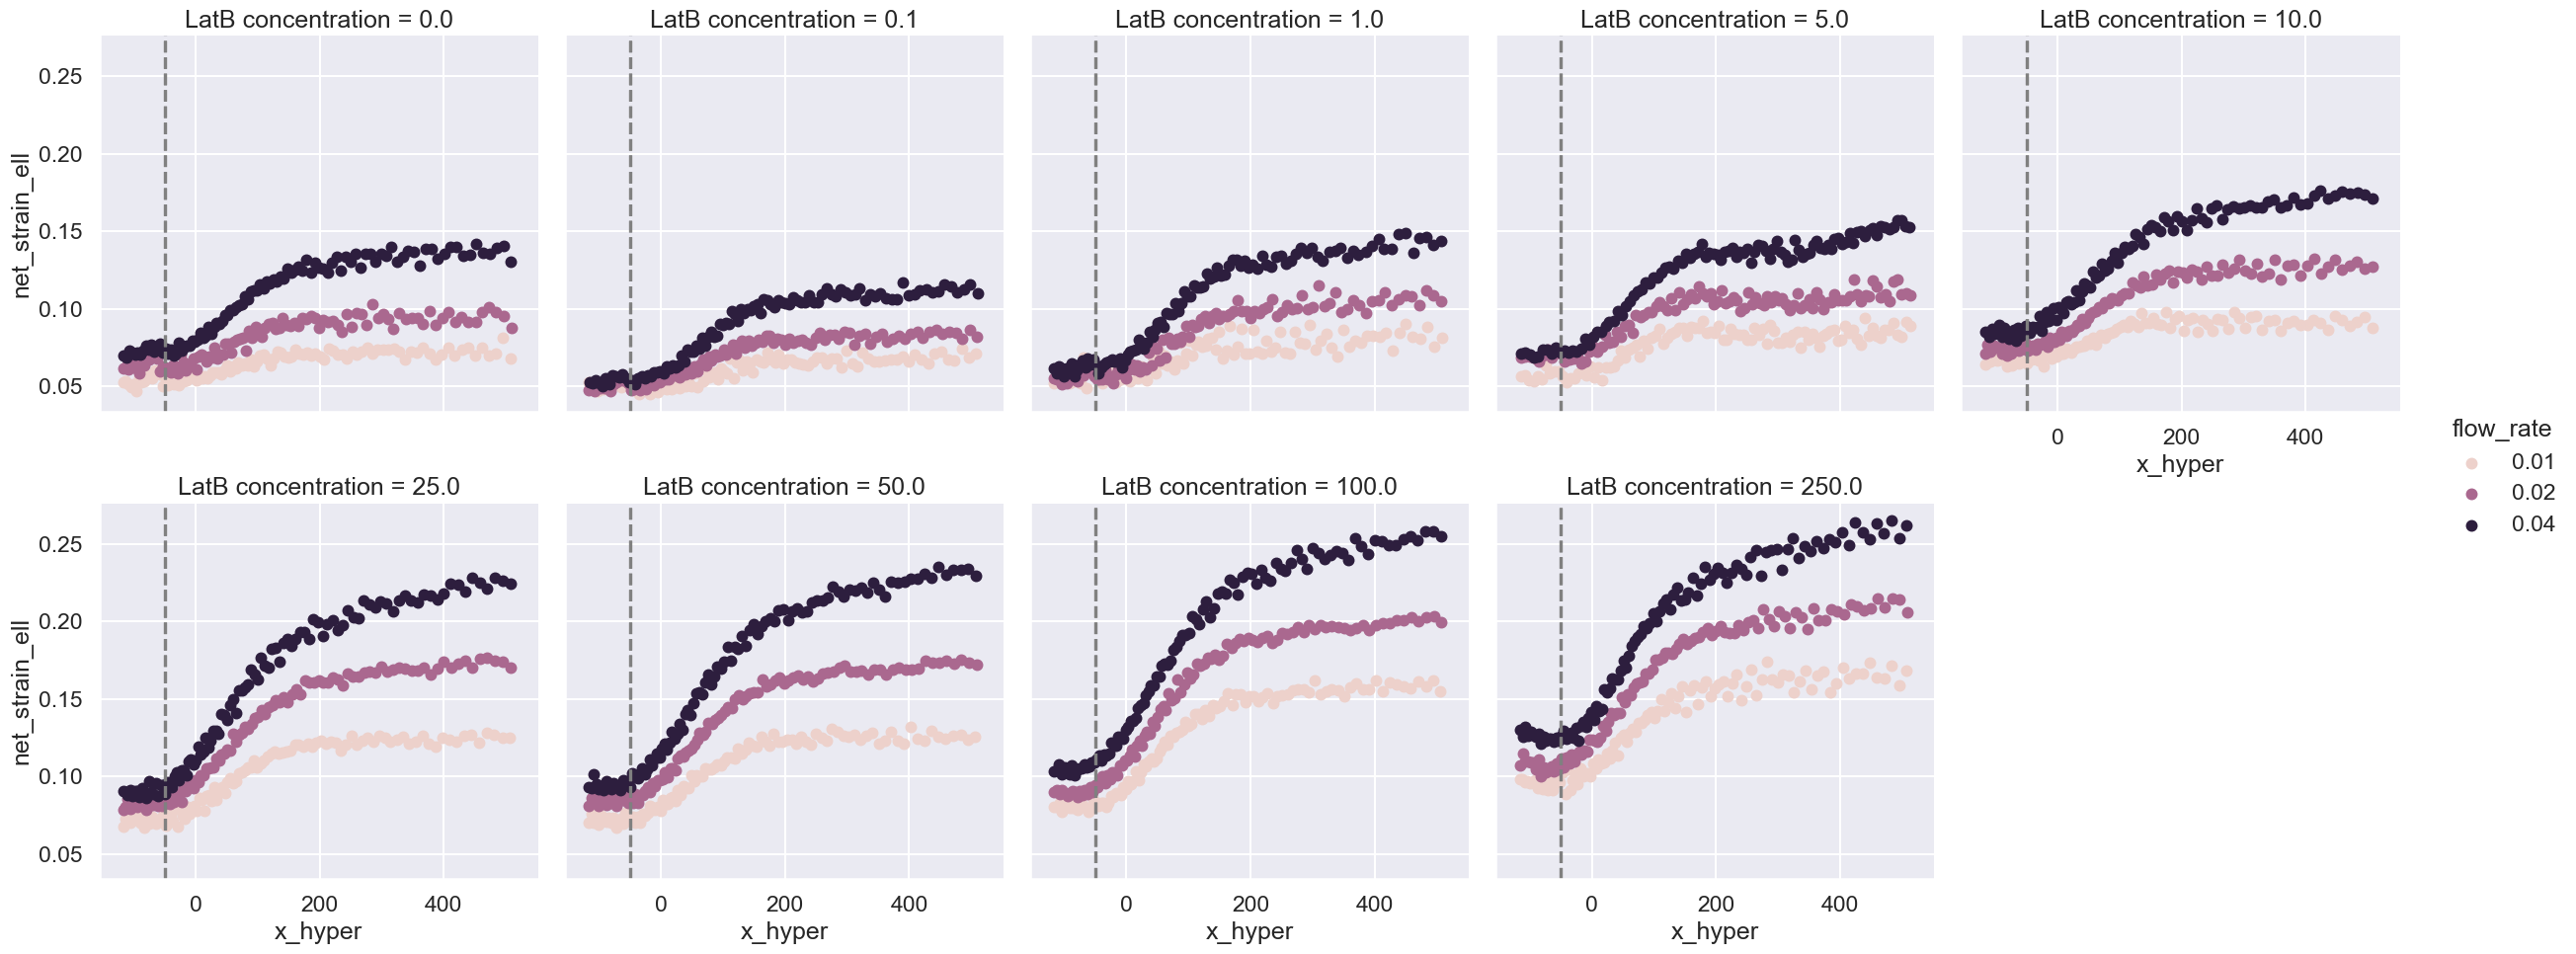

In [32]:
g = sns.lmplot(data=df_20230912,
               x='x_hyper', y='net_strain_ell', hue='flow_rate', palette='ch:',
               col='LatB concentration', col_wrap=5,
               x_bins=100, x_estimator=np.median, fit_reg=False, ci=None,
               facet_kws={'sharey': True})
g.refline(x=x0, markersize=0)
plt.show()

In [33]:
df_20230912

area_msd  area_ratio    area_um    aspect  bright_avg  bright_sd  \
0           447.0    1.055929  218.25280  1.080000  129.130170  27.050182   
1           439.5    1.056883  214.78480  1.080000  128.021010  27.321222   
2           437.0    1.051487  212.47281  1.080000  128.065540  27.449009   
3           439.0    1.046697  212.47281  1.080000  128.669480  27.905672   
4           431.5    1.039397  207.38641  1.000000  128.019270  27.809263   
...           ...         ...        ...       ...         ...        ...   
1101517     350.5    1.041369  168.77600  1.045454  122.710180  31.770260   
1101518     353.0    1.036827  169.23840  1.045454  122.415580  31.675198   
1101519     352.5    1.042553  169.93200  1.045454  121.257140  31.881907   
1101520     351.5    1.034139  168.08241  1.045454  120.088776  32.305940   
1101521     348.5    1.034433  166.69520  1.045454  119.139470  32.798492   

             circ    deform  ell_angle      ell_cx  ...  normal_stress_ir  \
0        0.982705  0.017295   0.547730  976.960713  ...          0.403595   
1        0.982296  0.017704   0.527157  966.917733  ...          0.233932   
2        0.981058  0.018942   0.613890  956.922729  ...          0.131605   
3        0.979793  0.020207   0.507601  947.041322  ...          0.074085   
4        0.989435  0.010565   0.734707  936.923178  ...          0.045002   
...           ...       ...        ...         ...  ...               ...   
1101517  0.981708  0.018292   2.647078  878.663998  ...          1.751442   
1101518  0.987669  0.012331   2.649079  862.837229  ...          2.876863   
1101519  0.984931  0.015068   2.655765  846.752703  ...          4.374026   
1101520  0.985690  0.014310   2.760909  830.179237  ...          6.249442   
1101521  0.984266  0.015734   2.734496  813.258128  ...          8.411193   

         stress_ell  shear_stress_ell  normal_stress_ell  LatB concentration  \
0          1.163622          0.311397           0.852224                 0.1   
1          0.849224          0.306353           0.542871                 0.1   
2          0.641695          0.304313           0.337382                 0.1   
3          0.515753          0.305967           0.209786                 0.1   
4          0.436897          0.297980           0.138917                 0.1   
...             ...               ...                ...                 ...   
1101517    3.844688          0.976135           2.868553                 0.0   
1101518    5.303252          0.979310           4.323942                 0.0   
1101519    7.093376          0.979101           6.114275                 0.0   
1101520    9.186398          0.973779           8.212619                 0.0   
1101521   11.464567          0.965138          10.499429                 0.0   

             date  wc  strain_inert  net_strain_ell  taylor_strain_ell  
0        20230912  60      0.030883        0.107862           0.053853  
1        20230912  60      0.017086        0.081913           0.040922  
2        20230912  60      0.004492        0.079206           0.039572  
3        20230912  60      0.009155        0.058481           0.029228  
4        20230912  60      0.005679        0.061788           0.030879  
...           ...  ..           ...             ...                ...  
1101517  20230912  60      0.041765        0.074575           0.037262  
1101518  20230912  60      0.055697        0.096542           0.048215  
1101519  20230912  60      0.050741        0.088161           0.044038  
1101520  20230912  60      0.061705        0.080974           0.040454  
1101521  20230912  60      0.077910        0.107450           0.053648  

[1101522 rows x 65 columns]

In [34]:
data_folder = os.path.join(data_exports, "20230912_HL60_LatB")
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)
filename = "20230913_hl60_latb_hyper.tsv"
df_20230912.to_csv(os.path.join(data_folder, filename), sep='\t')
print("Done")

Done


### Summarize inlet data

In [35]:
def get_folder_data_inlet(folder):
    # print("Analyzing ", folder)
    files = glob.glob(os.path.join(folder, "*.rtdc"))

    df_folder = pd.DataFrame()

    for file in tqdm(files):
        tr_ds = dctrack.track.TrackedDataSet(file)
        flow_rate = np.round(tr_ds.dataset.config['setup']['flow rate'], 3)
        # hyperbola start 500 um before channel
        hyper_start = tr_ds.channel_x_min * tr_ds.pixel_size - 500

        df = compute_extensional_paras(tr_ds,
                                       hyper_start=hyper_start,
                                       filter=True,
                                       max_back_movement=0,
                                       min_events=5)
        df['flow_rate'] = flow_rate
        roi_size_x = tr_ds.dataset.config['imaging']['roi size x']
        pix_size = tr_ds.dataset.config['imaging']['pixel size']
        df['pos_x_center'] = df['pos_x'] - roi_size_x * pix_size / 2

        df_folder = pd.concat([df_folder, df])

    return df_folder

In [36]:
for folder in tqdm(folder_names):
    print("Analyzing: ", folder)
    save_path = os.path.join(data_folder, folder + "_inlet.tsv")

    if not os.path.isfile(save_path):
        data_dir = os.path.join(project_folder, folder, "inlet")
        if folder == "DMSO":
            concentration = 0
        else:
            concentration = float(folder.split("_")[0][:-2])
        df_cc = get_folder_data_inlet(data_dir)
        df_cc['LatB concentration'] = concentration

        df_cc.to_csv(save_path, sep='\t')

  0%|          | 0/9 [00:00<?, ?it/s]

Analyzing:  DMSO


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  0.1nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  1nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  5nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  10nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  25nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  50nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  100nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  250nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
df_20230912_inlet = pd.DataFrame()
files_20230912_inlet = glob.glob(os.path.join(data_folder, "*inlet.tsv"))
for file in tqdm(files_20230912_inlet):
    df_cc = pd.read_csv(os.path.join(data_folder, file), sep='\t', index_col=0)
    df_20230912_inlet = pd.concat([df_20230912_inlet, df_cc], ignore_index=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [39]:
# df_20230912_inlet.drop(columns=['Unnamed: 0'], inplace=True)
df_20230912_inlet['date'] = '20230912'
df_20230912_inlet['wc'] = 60
df_20230912_inlet['strain_inert'] = df_20230912_inlet['inert_ratio_raw'] - 1
# ellipse features
df_20230912_inlet['net_strain_ell'] \
    = (df_20230912_inlet['ell_major'] - df_20230912_inlet['ell_minor']) \
      / np.sqrt(df_20230912_inlet['ell_major'] * df_20230912_inlet['ell_minor'])
df_20230912_inlet['taylor_strain_ell'] \
    = (df_20230912_inlet['ell_major'] - df_20230912_inlet['ell_minor']) \
      / (df_20230912_inlet['ell_major'] * df_20230912_inlet['ell_minor'])

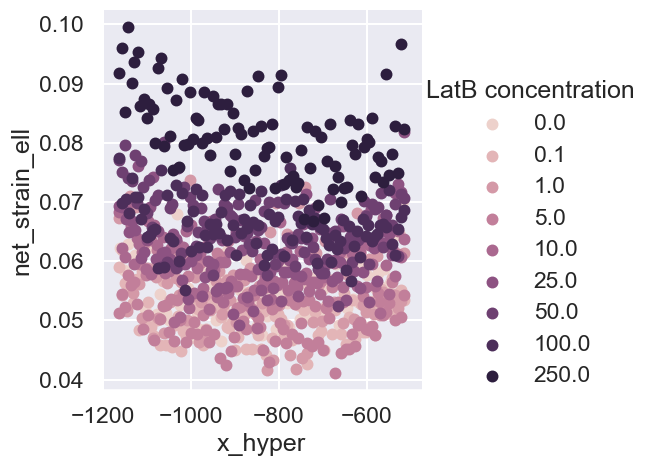

In [42]:
g = sns.lmplot(data=df_20230912_inlet,
               x='x_hyper', y='net_strain_ell', 
               hue='LatB concentration', palette='ch:',
               x_bins=100, x_estimator=np.median, fit_reg=False, ci=None,
               facet_kws={'sharey': True})
# g.refline(x=x0, markersize=0)
plt.show()

In [43]:
data_folder = os.path.join(data_exports, "20230912_HL60_LatB")
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)
filename = "20230913_hl60_latb_inlet.tsv"
df_20230912_inlet.to_csv(os.path.join(data_folder, filename), sep='\t')
print("Done")

Done
